In [1]:
import os
import pandas as pd
import numpy as np
import pyedflib
from getpass import getpass
import re

In [2]:
# Directories
TUSZ_DIR = "/Users/stefn/cits4010/tusz/edf"
EVENT_CLASSES = ['fnsz', 'gnsz', 'spsz', 'cpsz', 'absz', 'tnsz', 'tcsz', 'bckg']
DEFAULT_CHANNELS = ['FP1-F7', 'FP2-F8', 'F3-C3', 'F4-C4', 'C3-P3', 'C4-P4', 'O1-O2', 'FZ-CZ', 'CZ-PZ']

def parse_csv_annotations(csv_file):
    """
    Extracts seizure event annotations from a .csv file.
    Args:
    - csv_file (str): Path to the .csv file containing annotations.

    Returns:
    - pd.DataFrame: DataFrame containing seizure start, stop, channel index, and type.
    """
    try:
        # Skip comment lines and set the correct delimiter
        df = pd.read_csv(csv_file, sep=",", comment='#', skip_blank_lines=True)
        df.columns = ['channel', 'start_time', 'stop_time', 'label', 'confidence']
        df = df[['start_time', 'stop_time', 'channel', 'label']]  # Keep relevant columns
        return df[df['label'].isin(EVENT_CLASSES)]

    except pd.errors.ParserError as e:
        print(f"ParserError for file {csv_file}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

    except ValueError as ve:
        print(f"ValueError for file {csv_file}: {ve}")
        return pd.DataFrame()

# Function to load EDF files using annotations
def load_eeg_with_annotations(edf_file, annotations, channels=DEFAULT_CHANNELS, num_timesteps=256):
    """
    Loads EEG data corresponding to annotated events.
    Args:
    - edf_file (str): Path to the .edf file.
    - annotations (pd.DataFrame): DataFrame containing seizure start, stop, channel index, and type.
    - channels (List[str]): List of channels to include.
    - num_timesteps (int): Number of timesteps per EEG segment.

    Returns:
    - List of tuples (np.ndarray, str): Each tuple contains EEG segment data and event type.
    """
    segments = []
    try:
        f = pyedflib.EdfReader(edf_file)
        channel_labels = f.getSignalLabels()

        for _, row in annotations.iterrows():
            start = int(row['start_time'] * f.getSampleFrequency(0))
            stop = int(row['stop_time'] * f.getSampleFrequency(0))
            signal = np.zeros((len(channels), num_timesteps))

            for idx, channel in enumerate(channels):
                if channel in channel_labels:
                    channel_index = channel_labels.index(channel)
                    channel_signal = f.readSignal(channel_index)[start:stop]
                    if len(channel_signal) < num_timesteps:
                        # Padding if signal is shorter than expected
                        signal[idx, :len(channel_signal)] = channel_signal
                    else:
                        signal[idx, :] = channel_signal[:num_timesteps]

            segments.append((signal, row['label']))

    except Exception as e:
        print(f"Error loading EDF file {edf_file}: {e}")

    finally:
        if 'f' in locals():
            f.close()

    return segments

# Function to preprocess EEG data segments
def preprocess_segments(segments):
    """
    Preprocess EEG segments: normalize and pad/truncate.
    Args:
    - segments (List[Tuple[np.ndarray, str]]): List of tuples containing EEG segments and event types.

    Returns:
    - List of tuples (np.ndarray, str): Preprocessed EEG segments.
    """
    preprocessed_segments = []

    for signal, event in segments:
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True)

        # Avoid division by zero
        std[std == 0] = 1

        normalized_signal = (signal - mean) / std
        preprocessed_segments.append((normalized_signal, event))

    return preprocessed_segments


# Function to load and preprocess all EEG segments
def load_and_preprocess_all_segments(directory, channels=DEFAULT_CHANNELS, num_timesteps=256):
    """
    Load and preprocess all EEG segments from all subdirectories.
    Args:
    - directory (str): Base directory path containing the TUSZ data.
    - channels (List[str]): List of channels per EEG segment.
    - num_timesteps (int): Number of timesteps per EEG segment.

    Returns:
    - List of tuples (np.ndarray, str): All preprocessed EEG segments with labels.
    """
    all_segments = []
    for root, _, files in os.walk(directory):
        edf_files = [f for f in files if f.endswith('.edf')]
        for edf_file in edf_files:
            base_name = edf_file[:-4]
            csv_file = os.path.join(root, base_name + '.csv')
            if os.path.exists(csv_file):
                annotations = parse_csv_annotations(csv_file)
                edf_path = os.path.join(root, edf_file)
                segments = load_eeg_with_annotations(edf_path, annotations, channels, num_timesteps)
                preprocessed_segments = preprocess_segments(segments)
                all_segments.extend(preprocessed_segments)

    return all_segments

# Example: Loading and Preprocessing the Training Dataset
train_segments = load_and_preprocess_all_segments(TUSZ_DIR + '/train')
dev_segments = load_and_preprocess_all_segments(TUSZ_DIR + '/dev')
eval_segments = load_and_preprocess_all_segments(TUSZ_DIR + '/eval')

# Convert segments to arrays or tensors suitable for training
def prepare_data(segments):
    """
    Prepares data and labels for deep learning.
    Args:
    - segments (List[Tuple[np.ndarray, str]]): EEG segments with labels.

    Returns:
    - np.ndarray: EEG data array.
    - np.ndarray: Corresponding labels.
    """
    X = []
    y = []
    label_map = {event: idx for idx, event in enumerate(EVENT_CLASSES)}

    for signal, event in segments:
        X.append(signal)
        y.append(label_map[event])

    return np.array(X), np.array(y)

# Prepare datasets
X_train, y_train = prepare_data(train_segments)
X_dev, y_dev = prepare_data(dev_segments)
X_eval, y_eval = prepare_data(eval_segments)

# Example output shapes
print("Training Data:", X_train.shape, y_train.shape)
print("Development Data:", X_dev.shape, y_dev.shape)
print("Evaluation Data:", X_eval.shape, y_eval.shape)


Training Data: (149036, 9, 256) (149036,)
Development Data: (26444, 9, 256) (26444,)
Evaluation Data: (7416, 9, 256) (7416,)


In [3]:
# Load annotations from a .csv file
csv_file = "/Users/stefn/cits4010/tusz/edf/train/aaaaaizz/s003_2010/02_tcp_le/aaaaaizz_s003_t001.csv"
annotations = parse_csv_annotations(csv_file)

# Check the annotations
print(annotations)

     start_time  stop_time channel label
0        0.0000  1071.0303  FP1-F7  bckg
1     1071.0303  1083.9899  FP1-F7  cpsz
2     1083.9899  1494.0000  FP1-F7  bckg
3        0.0000  1494.0000   F7-T3  bckg
4        0.0000    57.8680   T3-T5  bckg
..          ...        ...     ...   ...
479   1424.0880  1431.9120   P4-O2  bckg
480   1431.9120  1453.9120   P4-O2  cpsz
481   1453.9120  1471.7120   P4-O2  bckg
482   1471.7120  1493.0000   P4-O2  cpsz
483   1493.0000  1494.0000   P4-O2  bckg

[484 rows x 4 columns]


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.label_map = {label: idx for idx, label in enumerate(set(labels))}

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.label_map[self.labels[idx]], dtype=torch.long)
        return x, y

# Using the previously defined load_and_preprocess_all_segments function
directory = "/Users/stefn/cits4010/tusz/edf"
data = load_and_preprocess_all_segments(directory, 'train')

# Prepare features and labels
X, y = zip(*data)
X = np.array([np.array(x) for x in X])
y = np.array(y)

# Create PyTorch Dataset and DataLoader
dataset = EEGDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example iteration over DataLoader
for batch_x, batch_y in dataloader:
    print(batch_x.shape, batch_y.shape)
    break


torch.Size([32, 5, 256]) torch.Size([32])


Training Data: (149036, 9, 256) (149036,)
Development Data: (26444, 9, 256) (26444,)
Evaluation Data: (7416, 9, 256) (7416,)


/var/folders/73/741h2hzd4k93zpm_pwxjrwm40000gn/T/ipykernel_77738/3620623183.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/73/741h2hzd4k93zpm_pwxjrwm40000gn/T/ipykernel_77738/3620623183.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/73/741h2hzd4k93zpm_pwxjrwm40000gn/T/ipykernel_77738/3620623183.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


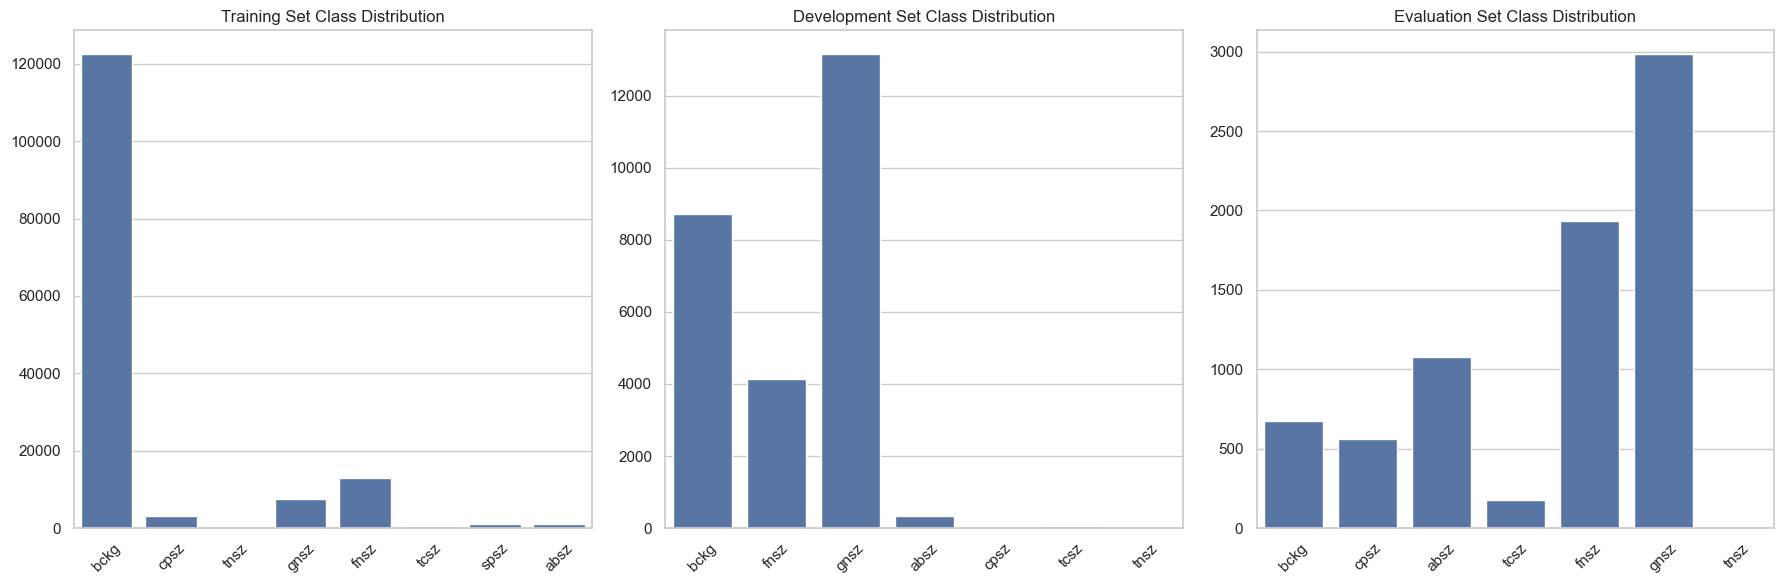

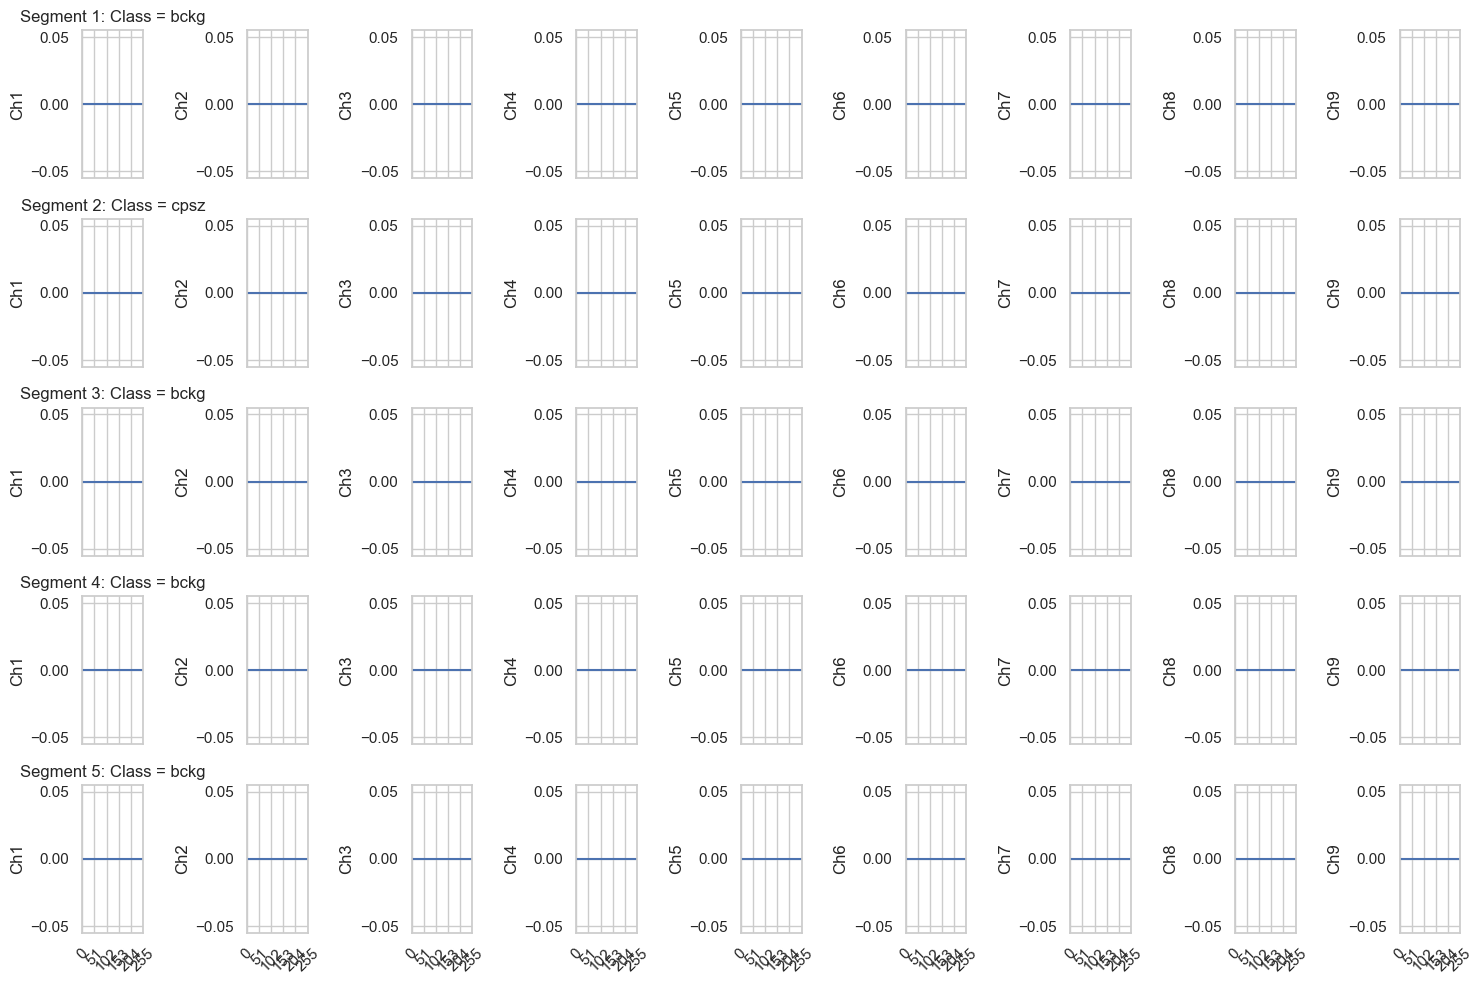

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set seaborn style for better plots
sns.set(style="whitegrid")

# Function to verify shapes
def verify_shapes(X_train, y_train, X_dev, y_dev, X_eval, y_eval):
    print("Training Data:", X_train.shape, y_train.shape)
    print("Development Data:", X_dev.shape, y_dev.shape)
    print("Evaluation Data:", X_eval.shape, y_eval.shape)

# Function to check class distribution
def verify_class_distribution(y_train, y_dev, y_eval, event_classes):
    # Create a mapping from index to class name
    index_to_class = {idx: event for idx, event in enumerate(event_classes)}

    # Function to translate numeric labels to class names
    def translate_labels(y):
        return [index_to_class[label] for label in y]

    # Translate labels
    y_train_labels = translate_labels(y_train)
    y_dev_labels = translate_labels(y_dev)
    y_eval_labels = translate_labels(y_eval)

    # Count class occurrences
    train_dist = Counter(y_train_labels)
    dev_dist = Counter(y_dev_labels)
    eval_dist = Counter(y_eval_labels)

    # Plot class distributions
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    sns.barplot(x=list(train_dist.keys()), y=list(train_dist.values()), ax=axs[0])
    sns.barplot(x=list(dev_dist.keys()), y=list(dev_dist.values()), ax=axs[1])
    sns.barplot(x=list(eval_dist.keys()), y=list(eval_dist.values()), ax=axs[2])

    axs[0].set_title("Training Set Class Distribution")
    axs[1].set_title("Development Set Class Distribution")
    axs[2].set_title("Evaluation Set Class Distribution")

    for ax in axs:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

# Function to visualize a few EEG segments
def visualize_segments(X, y, event_classes, num_segments=5):
    index_to_class = {idx: event for idx, event in enumerate(event_classes)}

    num_channels = X[0].shape[0]
    fig, axs = plt.subplots(num_segments, num_channels, figsize=(15, 10), sharex=True)

    for i in range(num_segments):
        for j in range(num_channels):
            axs[i, j].plot(np.arange(X[i].shape[1]), X[i][j, :])
            if j == 0:
                axs[i, j].set_title(f"Segment {i + 1}: Class = {index_to_class[y[i]]}")
            axs[i, j].set_ylabel(f"Ch{j+1}")
        axs[i, 0].set_xlim([0, X[i].shape[1]])

    for ax in axs.flat:
        ax.set_xticks(np.arange(0, X[0].shape[1] + 1, X[0].shape[1] // 5))
        ax.set_xticklabels(np.arange(0, X[0].shape[1] + 1, X[0].shape[1] // 5), rotation=45)

    plt.tight_layout()
    plt.show()

# Verify shapes
verify_shapes(X_train, y_train, X_dev, y_dev, X_eval, y_eval)

# Verify class distribution
verify_class_distribution(y_train, y_dev, y_eval, EVENT_CLASSES)

# Visual inspection of some segments
visualize_segments(X_train, y_train, EVENT_CLASSES, num_segments=5)



In [6]:
def check_raw_data(segments, num_samples=5):
    print("Checking raw data for variability:")
    for i in range(num_samples):
        signal, event = segments[i]
        print(f"Segment {i+1} ({event}): Min={np.min(signal)}, Max={np.max(signal)}, Mean={np.mean(signal)}, Std={np.std(signal)}")


In [7]:
def preprocess_segments(segments):
    preprocessed_segments = []
    for signal, event in segments:
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True)
        
        # Adjust normalization condition to prevent over-flattening
        std[std < 0.01] = 1  # Adjust threshold as necessary
        
        normalized_signal = (signal - mean) / std
        preprocessed_segments.append((normalized_signal, event))
    return preprocessed_segments


In [8]:
def visualize_segments(X, y, event_classes, num_segments=5):
    index_to_class = {idx: event for idx, event in enumerate(event_classes)}
    num_channels = X[0].shape[0]
    fig, axs = plt.subplots(num_segments, num_channels, figsize=(15, 10), sharex=True)
    
    for i in range(num_segments):
        for j in range(num_channels):
            axs[j].plot(X[i][j, :])
            axs[j].set_title(f"Channel {j+1}: {index_to_class[y[i]]}")
            axs[j].autoscale(enable=True, axis='both', tight=True)
    
    plt.tight_layout()
    plt.show()


Checking raw data for variability:
Segment 1 (bckg): Min=0.0, Max=0.0, Mean=0.0, Std=0.0
Segment 2 (cpsz): Min=0.0, Max=0.0, Mean=0.0, Std=0.0
Segment 3 (bckg): Min=0.0, Max=0.0, Mean=0.0, Std=0.0
Segment 4 (bckg): Min=0.0, Max=0.0, Mean=0.0, Std=0.0
Segment 5 (bckg): Min=0.0, Max=0.0, Mean=0.0, Std=0.0


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

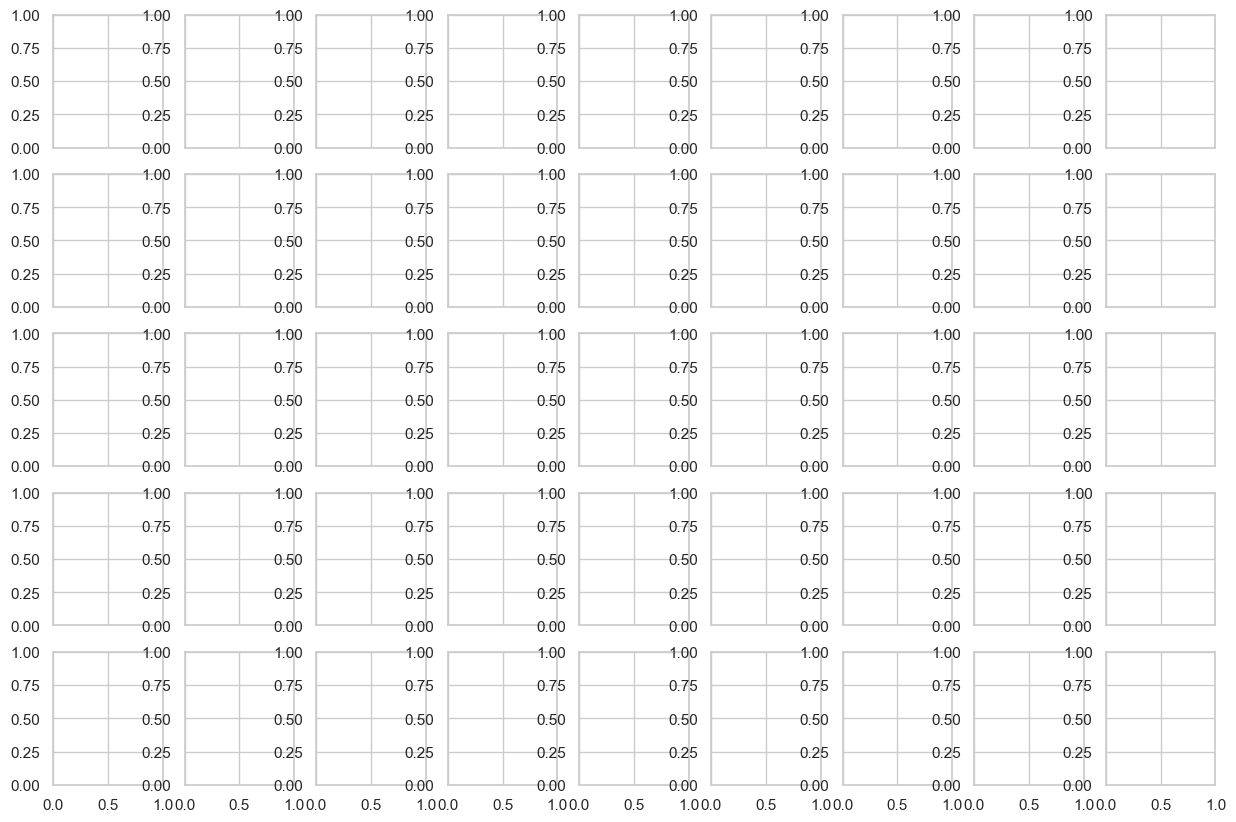

In [9]:
# Load and preprocess data again
train_segments = load_and_preprocess_all_segments(TUSZ_DIR + '/train')
# Check raw data variability
check_raw_data(train_segments)
# Visualize adjusted segments
visualize_segments(X_train, y_train, EVENT_CLASSES, num_segments=5)


In [11]:
import math
import tensorflow as tf
from keras.models import Model
from keras.layers import (Input, Conv1D, Multiply, Add, Dense, Dropout, 
                          AveragePooling1D, Bidirectional, LSTM)
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

# WaveNet Block
def wave_block(x, filters, kernel_size, dilation_rates):
    x = Conv1D(filters=filters, kernel_size=1, padding='same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters=filters, kernel_size=kernel_size, 
                          padding='same', activation='tanh', dilation_rate=dilation_rate)(x)
        sigm_out = Conv1D(filters=filters, kernel_size=kernel_size, 
                          padding='same', activation='sigmoid', dilation_rate=dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters=filters, kernel_size=1, padding='same')(x)
        res_x = Add()([res_x, x])
    return res_x

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, step_dim, **kwargs):
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.features_dim = input_shape[-1]
        self.W = self.add_weight(name='W', shape=(self.features_dim,), initializer='glorot_uniform')
        self.b = self.add_weight(name='b', shape=(self.step_dim,), initializer='zero')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        eij = tf.keras.backend.dot(x, tf.keras.backend.reshape(self.W, (self.features_dim, 1)))
        eij = tf.keras.backend.reshape(eij, (-1, self.step_dim))
        eij += self.b
        eij = tf.keras.backend.tanh(eij)
        a = tf.keras.backend.exp(eij)
        a /= tf.keras.backend.cast(tf.keras.backend.sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.keras.backend.floatx())
        a = tf.keras.backend.expand_dims(a)
        return tf.keras.backend.sum(x * a, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Conditional Pooling Function
def conditional_pooling(x, pool_size):
    if x.shape[1] < pool_size:
        return x
    return AveragePooling1D(pool_size)(x)
    
# WaveNet-LSTM Model
def wavenet_lstm_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    
    # WaveNet Blocks
    x = wave_block(inp, 16, 3, [1, 2, 4, 8, 16, 32])
    x = conditional_pooling(x, 2)  # Adjust pool size
    x = wave_block(x, 32, 3, [1, 2, 4, 8])
    x = conditional_pooling(x, 2)  # Adjust pool size
    x = wave_block(x, 64, 3, [1, 2, 4])
    x = conditional_pooling(x, 2)  # Adjust pool size
    
    # LSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = AttentionLayer(x.shape[1])(x)
    x = Dropout(0.5)(x)
    
    # Dense Layers
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=x)
    return model


In [12]:
# Hyperparameters
input_shape = (256, 9)  # Adjust according to your preprocessed data
num_classes = len(EVENT_CLASSES)  # Number of classes (ensure this is correct)
model = wavenet_lstm_model(input_shape, num_classes)
model.summary()

# Compile the Model
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lr_decay = LearningRateScheduler(step_decay)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Callbacks
checkpoint = ModelCheckpoint("wavenet_lstm_best.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
callbacks = [checkpoint, lr_decay, early_stopping]

# Transpose the Data
X_train = np.transpose(X_train, (0, 2, 1))
X_dev = np.transpose(X_dev, (0, 2, 1))
X_eval = np.transpose(X_eval, (0, 2, 1))

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_dev = to_categorical(y_dev, num_classes=num_classes)
y_eval = to_categorical(y_eval, num_classes=num_classes)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 9)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 16)      160         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 256, 16)      784         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 256, 16)      784         ['conv1d[0][0]']                 
                                                                                              

In [13]:
# Train the Model
model.fit(X_train, y_train, validation_data=(X_dev, y_dev),
          epochs=100, batch_size=32, callbacks=callbacks, verbose=1)

# Evaluate the Model
score = model.evaluate(X_eval, y_eval, verbose=0)
print(f"Evaluation Loss: {score[0]}, Accuracy: {score[1]}")

2024-05-19 16:13:35.988089: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
4657/4658 [============================>.] - ETA: 0s - loss: 0.9538 - accuracy: 0.8219
Epoch 1: val_loss improved from inf to 2.05424, saving model to wavenet_lstm_best.hdf5
4658/4658 [==============================] - 495s 105ms/step - loss: 0.9537 - accuracy: 0.8219 - val_loss: 2.0542 - val_accuracy: 0.3294 - lr: 0.0010
Epoch 2/100
4657/4658 [============================>.] - ETA: 0s - loss: 0.7113 - accuracy: 0.8221
Epoch 2: val_loss improved from 2.05424 to 2.03912, saving model to wavenet_lstm_best.hdf5
4658/4658 [==============================] - 659s 142ms/step - loss: 0.7113 - accuracy: 0.8221 - val_loss: 2.0391 - val_accuracy: 0.3294 - lr: 0.0010
Epoch 3/100
4658/4658 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.8221
Epoch 3: val_loss improved from 2.03912 to 2.01126, saving model to wavenet_lstm_best.hdf5
4658/4658 [==============================] - 455s 98ms/step - loss: 0.7095 - accuracy: 0.8221 - val_loss: 2.0113 - val_accuracy: 0.329